In [31]:
import torch
import gym
from numpy.random import choice
from copy import deepcopy
from torch.nn.utils.convert_parameters import parameters_to_vector
from torch.nn.utils.convert_parameters import vector_to_parameters

In [32]:


class TRPOAgent:
    """Continuous TRPO agent."""

    def __init__(self, policy, discount=0.98, kl_delta=0.01, cg_iteration=10,
                 cg_dampening=0.001, cg_tolerance=1e-10, cg_state_percent=0.1):
        self.policy = policy
        self.discount = discount
        self.kl_delta = kl_delta
        self.cg_iteration = cg_iteration
        self.cg_dampening = cg_dampening
        self.cg_tolerance = cg_tolerance
        self.cg_state_percent = cg_state_percent
        self.distribution = torch.distributions.normal.Normal

        # Cuda check
        self.device = (torch.device('cuda') if torch.cuda.is_available()
                       else torch.device('cpu'))
        policy.to(self.device)

        # Infer action dimensions from policy
        policy_modules = [module for module in policy.modules() if not
                          isinstance(module, torch.nn.Sequential)]
        action_dims = policy_modules[-1].out_features

        # Set logstd
        self.logstd = torch.ones(action_dims, requires_grad=True,
                                 device=self.device)
        with torch.no_grad():
            self.logstd /= self.logstd.exp()

        self.buffers = {'log_probs': [], 'actions': [],
                        'completed_rewards': [], 'states': []}

    def __call__(self, state):
        """
        Peforms forward pass on the NN and parameterized distribution.

        Parameters
        ----------
        state : torch.Tensor
            Tensor passed into NN and distribution.

        Returns
        -------
            Action choice for each action dimension.
        """
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)

        # Parameterize distribution with policy, sample action
        normal_dist = self.distribution(self.policy(state), self.logstd.exp())
        action = normal_dist.sample()
        # Save information
        self.buffers['actions'].append(action)
        self.buffers['log_probs'].append(normal_dist.log_prob(action))
        self.buffers['states'].append(state)
        return action.cpu().numpy()

    def kl(self, new_policy, new_std, states, grad_new=True):
        """Compute KL divergence between current policy and new one.

        Parameters
        ----------
        new_policy : TRPOAgent
        new_std : torch.Tensor
        states : torch.Tensor
            States to compute KL divergence over.
        grad_new : bool, optional
            Enable gradient of new policy.
        """
        mu1 = self.policy(states)
        log_sigma1 = self.logstd
        mu2 = new_policy(states)
        log_sigma2 = new_std

        # Detach other as gradient should only be w.r.t. to one
        if grad_new:
            mu1, log_sigma1 = mu1.detach(), log_sigma1.detach()
        else:
            mu2, log_sigma2 = mu2.detach(), log_sigma2.detach()

        # Compute KL over all states
        kl_matrix = ((log_sigma2 - log_sigma1) + 0.5 * (log_sigma1.exp().pow(2)
                     + (mu1 - mu2).pow(2)) / log_sigma2.exp().pow(2) - 0.5)

        # Sum over action dim, average over all states
        return kl_matrix.sum(1).mean()

    def surrogate_objective(self, new_policy, new_std, states, actions,
                            log_probs, advantages):
        new_dist = self.distribution(new_policy(states), new_std.exp())
        new_prob = new_dist.log_prob(actions)

        entropy_bonus = new_dist.entropy().mean()

        # Detach old log_probs, only compute grad w.r.t. new policy
        ratio = new_prob.exp() / log_probs.detach().exp()

        return (ratio * advantages.view(-1, 1)).mean() + 1e-3 * entropy_bonus

    def line_search(self, gradients, states, actions, log_probs, rewards):
        step_size = (2 * self.kl_delta / gradients.dot(
            self.fisher_vector_direct(gradients, states))).sqrt()
        step_size_decay = 1.5
        line_search_attempts = 10

        # New policy
        current_parameters = parameters_to_vector(self.policy.parameters())
        new_policy = deepcopy(self.policy)
        vector_to_parameters(current_parameters + step_size * gradients,
                             new_policy.parameters())
        new_std = self.logstd.detach() + step_size * self.logstd.grad

        #  Shrink gradient until KL constraint met and improvement
        for attempt in range(line_search_attempts):
            # Obtain kl divergence and objective
            with torch.no_grad():
                kl_value = self.kl(new_policy, new_std, states)
                objective = self.surrogate_objective(new_policy, new_std,
                                                     states, actions, log_probs,
                                                     rewards)

            # Shrink gradient if KL constraint not met or reward lower
            if kl_value > self.kl_delta or objective < 0:
                step_size /= step_size_decay
                vector_to_parameters(current_parameters + step_size *
                                     gradients, new_policy.parameters())
                new_std = self.logstd.detach() + step_size * self.logstd.grad
            #  Return new policy and std if KL and reward met
            else:
                return new_policy, new_std.requires_grad_()

        # Return old policy and std if constraints never met
        return self.policy, self.logstd

    def fisher_vector_direct(self, vector, states):
        """Computes the fisher vector product through direct method.

        The FVP can be determined by first taking the gradient of KL
        divergence w.r.t. the parameters and the dot product of this
        with the input vector, then a gradient over this again w.r.t.
        the parameters.
        """
        vector = vector.clone().requires_grad_()
        # Gradient of KL w.r.t. network param
        self.policy.zero_grad()
        kl_divergence = self.kl(self.policy, self.logstd, states)
        grad_kl = torch.autograd.grad(kl_divergence, self.policy.parameters(),
                                      create_graph=True)
        grad_kl = torch.cat([grad.view(-1) for grad in grad_kl])

        # Gradient of the gradient vector dot product w.r.t. param
        grad_vector_dot = grad_kl.dot(vector)
        fisher_vector_product = torch.autograd.grad(grad_vector_dot,
                                                    self.policy.parameters())
        fisher_vector_product = torch.cat([out.view(-1) for out in
                                           fisher_vector_product]).detach()

        # Apply CG dampening and return fisher vector product
        return fisher_vector_product + self.cg_dampening * vector.detach()

    def conjugate_gradient(self, b, states):
        """
        Solve Ax = b for A as FIM and b as initial gradient.

        Source:
        https://github.com/ikostrikov/pytorch-trpo/blob/master/trpo.py

        Slight modifications to original, all credit to original.
        """
        p = b.clone()
        r = b.clone().double()
        x = torch.zeros(*p.shape, device=self.device).double()
        rdotr = r.dot(r)
        for _ in range(self.cg_iteration):
            fvp = self.fisher_vector_direct(p, states).double()
            v = rdotr / p.double().dot(fvp)
            x += v * p.double()
            r -= v * fvp
            new_rdotr = r.dot(r)
            mu = new_rdotr / rdotr
            p = (r + mu * p.double()).float()
            rdotr = new_rdotr
            if rdotr < self.cg_tolerance:
                break
        return x.float()

    def optimize(self):
        # Return if no completed episodes
        if len(self.buffers['completed_rewards']) == 0:
            return
 
        # Convert all buffers to tensors
        num_batch_steps = len(self.buffers['completed_rewards'])
        rewards = torch.tensor(self.buffers['completed_rewards'])
        actions = torch.stack(self.buffers['actions'][:num_batch_steps])
        states = torch.stack(self.buffers['states'][:num_batch_steps])
        log_probs = torch.stack(self.buffers['log_probs'][:num_batch_steps])
        rewards, actions, states, log_probs = (rewards.to(self.device),
                                               actions.to(self.device), 
                                               states.to(self.device),
                                               log_probs.to(self.device))

        # Normalize rewards over episodes
        rewards = (rewards - rewards.mean()) / rewards.std()

        # Compute regular gradient
        self.surrogate_objective(self.policy, self.logstd, states, actions,
                                 log_probs, rewards).backward()
        gradients = parameters_to_vector(
            [param.grad for param in self.policy.parameters()])

        # Choose states for conjugate gradient with np.random.choice
        number_of_states = int(self.cg_state_percent * num_batch_steps)
        cg_states = states[choice(len(states), number_of_states, replace=False)]

        # Compute search direction as A^(-1)g, A is FIM
        gradients = self.conjugate_gradient(gradients, cg_states)
        # Find new policy and std with line search
        self.policy, self.logstd = self.line_search(gradients, states, actions,
                                                    log_probs, rewards)

        # Update buffers removing processed steps
        for key, storage in self.buffers.items():
            del storage[:num_batch_steps]

    def train(self, env_name, seed=None, batch_size=12000, iterations=100,
              max_episode_length=None, verbose=False):

        # Initialize env
        env = gym.make(env_name)
        if seed is not None:
            torch.manual_seed(seed)
            env.seed(seed)
        if max_episode_length is None:
            max_episode_length = 999
        # Recording
        recording = {'episode_reward': [[]],
                     'episode_length': [0],
                     'num_episodes_in_iteration': []}

        # Begin training
        observation = env.reset()
        if type(observation) == tuple:
            observation = observation[0]
        for iteration in range(iterations):
            # Set initial value to 0
            recording['num_episodes_in_iteration'].append(0)

            for step in range(batch_size):
                # Take step with agent
                #print()
                observation, reward, done, info,  _ = env.step(self(observation))

                # Recording, increment episode values
                recording['episode_length'][-1] += 1
                recording['episode_reward'][-1].append(reward)

                # End of episode
                if (done or
                        recording['episode_length'][-1] >= max_episode_length):
                    # Calculate discounted reward
                    discounted_reward = recording['episode_reward'][-1].copy()
                    for index in range(len(discounted_reward) - 2, -1, -1):
                        discounted_reward[index] += self.discount * \
                            discounted_reward[index + 1]
                    self.buffers['completed_rewards'].extend(discounted_reward)

                    # Set final recording of episode reward to total
                    recording['episode_reward'][-1] = \
                        sum(recording['episode_reward'][-1])
                    # Recording
                    recording['episode_length'].append(0)
                    recording['episode_reward'].append([])
                    recording['num_episodes_in_iteration'][-1] += 1

                    # Reset environment
                    observation = env.reset()
                    if type(observation) == tuple:
                        observation = observation[0]

            # Print information if verbose
            if verbose:
                num_episode = recording['num_episodes_in_iteration'][-1]
                avg = (round(sum(recording['episode_reward'][-num_episode:-1])
                             / (num_episode - 1), 3))
                print(f'Average Reward over Iteration {iteration}: {avg}')
            # Optimize after batch
            self.optimize()

        # Return recording information
        return recording

    def save_model(self, path):
        torch.save({
            'policy': self.policy.state_dict(),
            'logstd': self.logstd
        }, path)

    def load_model(self, path):
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint['policy'])
        self.logstd = checkpoint['logstd'].to(self.device)

In [36]:
import gym
import torch
import os
import pickle
import matplotlib.pyplot as plt

reward_list = []

In [40]:
for i in range(2):
    nn = torch.nn.Sequential(torch.nn.Linear(8, 32), torch.nn.Tanh(),
                            torch.nn.Linear(32, 2))
    init_weights = (lambda param: torch.nn.init.xavier_normal_(param.weight) if
                    isinstance(param, torch.nn.Linear) else None)
    nn.apply(init_weights)

    # Initialize the agent
    agent = TRPOAgent(policy=nn)

    policy_name = type(agent).__name__

    # Train
    records = agent.train('Swimmer-v4', batch_size=10000,
                        iterations=500, max_episode_length=500, verbose=True)

    rewards_per_iter = []
    s = e = 0
    for i in range(len(records['num_episodes_in_iteration'])):
        num = records['num_episodes_in_iteration'][i]
        e += records['num_episodes_in_iteration'][i]
        avg = sum(records['episode_reward'][s:e]) / num
        rewards_per_iter.append(avg)
        s = e
    reward_list.append(rewards_per_iter)
    
agent.save_model(f'{policy_name}.pth')
pickle.dump(records, open(f'{policy_name}_records.pickle', 'wb'))
#plot_info(records, policy_name)

# Display
'''
env = gym.make('MountainCarContinuous-v0', render_mode = "human")
ob = env.reset()
if type(ob) == tuple:
    ob = ob[0]
for i in range(2):
    action = agent(ob)
    ob, _, done, info, _ = env.step(action)
    #env.render()
    if done:
        ob = env.reset()
        if type(ob) == tuple:
            ob = ob[0]
'''

def plot_info(records, policy_name):
    rewards_per_iter = []
    s = e = 0
    for i in range(5, len(records['num_episodes_in_iteration'])):
        num = records['num_episodes_in_iteration'][i]
        e += records['num_episodes_in_iteration'][i]
        avg = sum(records['episode_reward'][s:e]) / num
        rewards_per_iter.append(avg)
        s = e
    print(max(rewards_per_iter))
    max_iter = max(enumerate(rewards_per_iter), key=lambda t: t[1])[0]
    plt.plot(list(range(5, len(rewards_per_iter) + 5)), rewards_per_iter)
    plt.text(min(max_iter, len(rewards_per_iter) - 10),
             rewards_per_iter[max_iter],
             "Max Reward: " + str(round(rewards_per_iter[max_iter], 2)))

    plt.title(f"{policy_name} reward per iter on Swimmer-v4")
    plt.ylabel("Reward")
    plt.xlabel("Iteration")
    plt.show()

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Average Reward over Iteration 0: -21.717
Average Reward over Iteration 1: -15.96
Average Reward over Iteration 2: -10.245
Average Reward over Iteration 3: 8.69
Average Reward over Iteration 4: 9.744
Average Reward over Iteration 5: 19.761
Average Reward over Iteration 6: 21.273
Average Reward over Iteration 7: 16.896
Average Reward over Iteration 8: 18.038
Average Reward over Iteration 9: 20.422
Average Reward over Iteration 10: 24.264
Average Reward over Iteration 11: 24.197
Average Reward over Iteration 12: 24.672
Average Reward over Iteration 13: 24.96
Average Reward over Iteration 14: 23.831
Average Reward over Iteration 15: 24.355
Average Reward over Iteration 16: 24.465
Average Reward over Iteration 17: 24.195
Average Reward over Iteration 18: 26.188
Average Reward over Iteration 19: 27.54
Average Reward over Iteration 20: 26.996
Average Reward over Iteration 21: 27.234
Average Reward over Iteration 22: 27.92
Average Reward over Iteration 23: 27.343
Average Reward over Iteration 

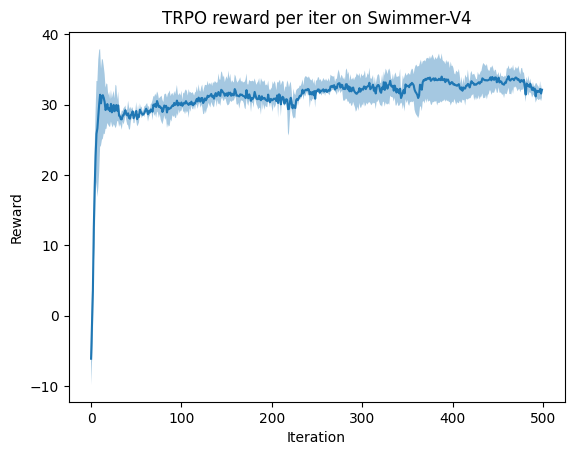

In [42]:
import numpy as np

par_1_75, par_1_25 = np.percentile(reward_list, [75, 25], axis = 0)
plt.plot(range(500), np.mean(reward_list , axis = 0))
plt.fill_between(range(500), par_1_25, par_1_75, alpha = 0.4)
plt.title(f"TRPO reward per iter on Swimmer-V4")
plt.ylabel("Reward")
plt.xlabel("Iteration")
plt.show()

In [43]:
import pickle
dataStore = {}

dataStore['TRPO'] = reward_list
    
with open('./' + 'Results_TRPO_SM' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
